In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo
plt.style.use('default')
sns.set_palette("husl")
colors = px.colors.qualitative.Plotly

# Simulação de dados (substituir pelos dados reais quando disponíveis)
np.random.seed(42)
countries = ['USA', 'China', 'India', 'Brazil', 'Russia', 'Japan', 'Germany', 'UK', 
             'France', 'Italy', 'South Africa', 'Mexico', 'Australia', 'Canada', 'Nigeria']
regions = ['North America', 'Asia', 'Asia', 'South America', 'Europe', 'Asia', 
           'Europe', 'Europe', 'Europe', 'Europe', 'Africa', 'North America', 
           'Oceania', 'North America', 'Africa']

# Criar DataFrame simulado
data = pd.DataFrame({
    'Country': countries,
    'Region': regions,
    'GDP_Per_Capita': np.random.lognormal(8.5, 1.2, len(countries)),
    'Poverty_Rate': np.random.uniform(2, 40, len(countries)),
    'Life_Expectancy': np.random.uniform(55, 85, len(countries)),
    'Education_Spending_Percent': np.random.uniform(2.5, 6.5, len(countries)),
    'Health_Expenditure_Percent': np.random.uniform(3.5, 11.5, len(countries)),
    'Literacy_Rate': np.random.uniform(70, 100, len(countries)),
    'Population': np.random.randint(1000000, 1400000000, len(countries))
})

# Calcular algumas métricas adicionais
data['Health_Expenditure_Per_Capita'] = data['GDP_Per_Capita'] * data['Health_Expenditure_Percent'] / 100
data['Education_Spending_Per_Capita'] = data['GDP_Per_Capita'] * data['Education_Spending_Percent'] / 100

# Ordenar por PIB per capita para melhor visualização
data = data.sort_values('GDP_Per_Capita', ascending=False)

print("Primeiras linhas do dataset:")
print(data.head())
print(f"\nDimensões do dataset: {data.shape}")
print(f"\nTipos de dados:\n{data.dtypes}")

Primeiras linhas do dataset:
   Country         Region  GDP_Per_Capita  Poverty_Rate  Life_Expectancy  \
6  Germany         Europe    32697.548302      9.587604        69.855307   
3   Brazil  South America    30565.763683     15.921750        75.526991   
7       UK         Europe    12343.954092     21.540909        56.031656   
2    India           Asia    10691.734504     13.101497        57.930163   
9    Italy         Europe     9424.538563      3.765116        62.763399   

   Education_Spending_Percent  Health_Expenditure_Percent  Literacy_Rate  \
6                    2.853970                    5.089725      91.888185   
3                    6.079309                    4.096405      71.906751   
7                    3.283931                    3.544177      89.126724   
2                    6.257996                    9.917576      79.926941   
9                    3.801321                    9.154859      84.166448   

   Population  Health_Expenditure_Per_Capita  Education_S

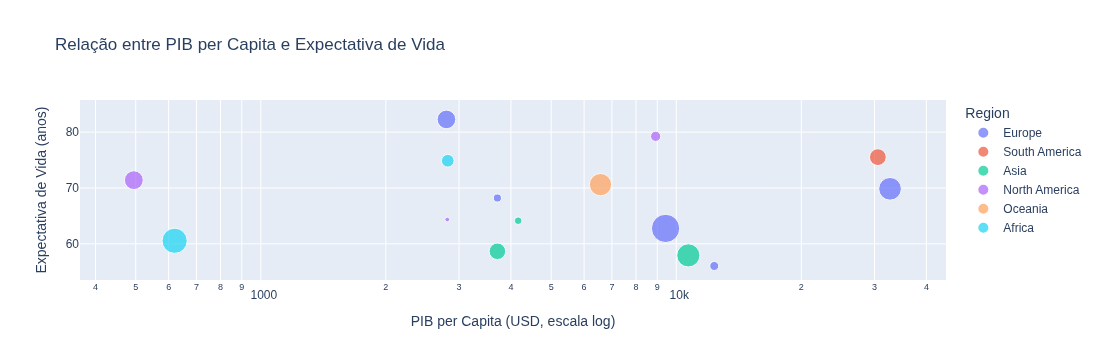

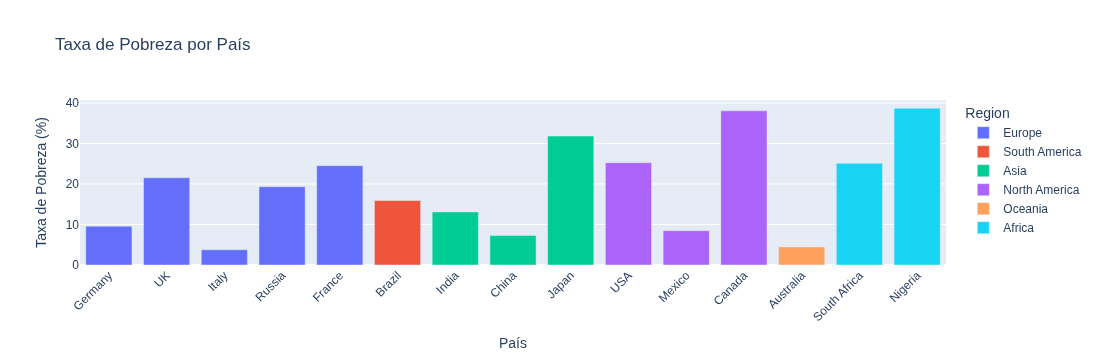

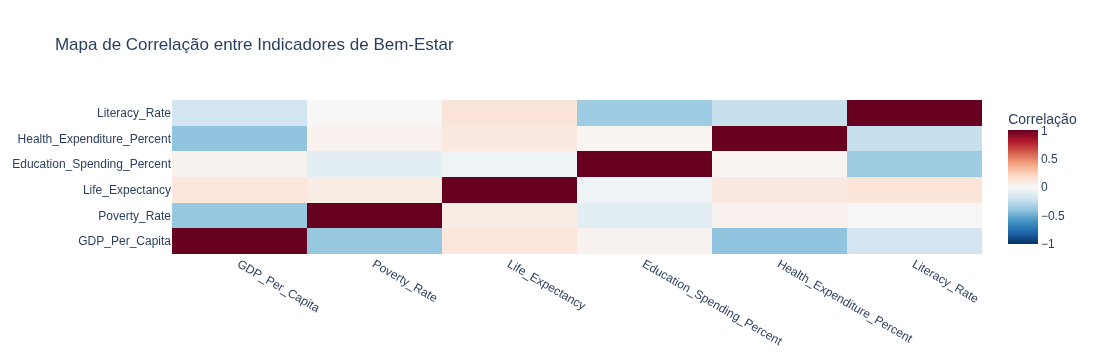

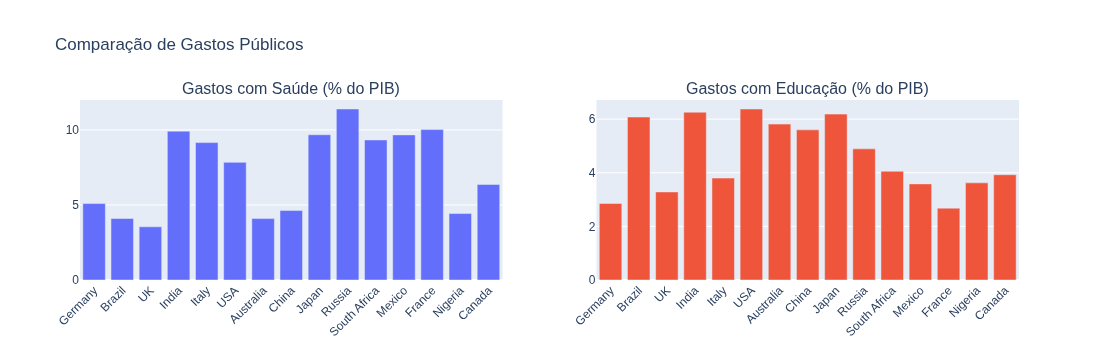

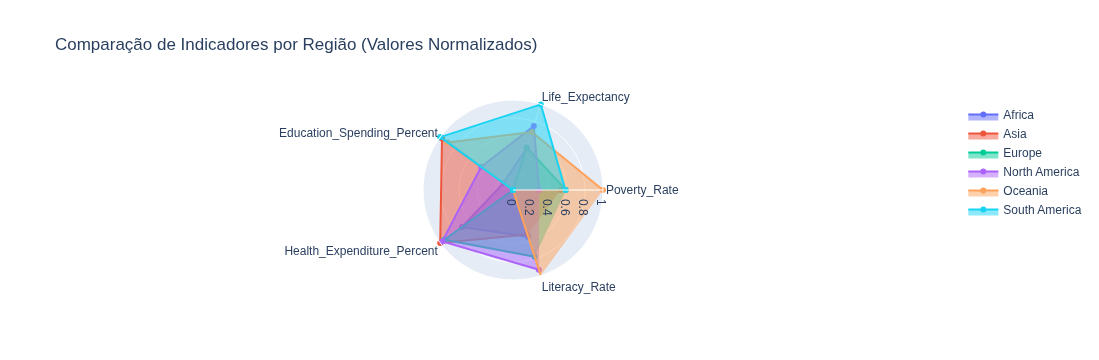

In [4]:
# 1. Gráfico de dispersão: PIB per capita vs Expectativa de Vida
fig1 = px.scatter(data, x='GDP_Per_Capita', y='Life_Expectancy',
                 size='Population', color='Region',
                 hover_name='Country', log_x=True,
                 title='Relação entre PIB per Capita e Expectativa de Vida',
                 labels={'GDP_Per_Capita': 'PIB per Capita (USD, escala log)', 
                         'Life_Expectancy': 'Expectativa de Vida (anos)'})
fig1.show()

# 2. Gráfico de barras: Taxa de pobreza por país
fig2 = px.bar(data, x='Country', y='Poverty_Rate', color='Region',
             title='Taxa de Pobreza por País',
             labels={'Poverty_Rate': 'Taxa de Pobreza (%)', 'Country': 'País'})
fig2.update_layout(xaxis_tickangle=-45)
fig2.show()

# 3. Mapa de correlações
corr_vars = ['GDP_Per_Capita', 'Poverty_Rate', 'Life_Expectancy', 
             'Education_Spending_Percent', 'Health_Expenditure_Percent', 'Literacy_Rate']
corr_matrix = data[corr_vars].corr()

fig3 = go.Figure(data=go.Heatmap(
                   z=corr_matrix,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='RdBu_r',
                   zmin=-1, zmax=1,
                   hoverongaps=False,
                   colorbar=dict(title="Correlação")))
fig3.update_layout(title='Mapa de Correlação entre Indicadores de Bem-Estar')
fig3.show()

# 4. Comparação entre gastos com saúde e educação
fig4 = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Gastos com Saúde (% do PIB)', 'Gastos com Educação (% do PIB)'))

fig4.add_trace(go.Bar(x=data['Country'], y=data['Health_Expenditure_Percent'],
                     name='Saúde', marker_color=colors[0]), row=1, col=1)
fig4.add_trace(go.Bar(x=data['Country'], y=data['Education_Spending_Percent'],
                     name='Educação', marker_color=colors[1]), row=1, col=2)

fig4.update_layout(showlegend=False, title_text='Comparação de Gastos Públicos')
fig4.update_xaxes(tickangle=-45)
fig4.show()

# 5. CORREÇÃO: Gráfico de radar para comparar múltiplos indicadores por região
# Selecionar apenas colunas numéricas para o cálculo da média
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
region_means = data.groupby('Region')[numeric_cols].mean().reset_index()

# Normalizar os dados para o gráfico de radar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

radar_vars = ['Poverty_Rate', 'Life_Expectancy', 'Education_Spending_Percent', 
              'Health_Expenditure_Percent', 'Literacy_Rate']
radar_data = region_means[radar_vars]
radar_data_normalized = pd.DataFrame(scaler.fit_transform(radar_data), 
                                    columns=radar_data.columns, 
                                    index=radar_data.index)

# Inverter a pobreza para que valores mais altos sejam melhores
radar_data_normalized['Poverty_Rate'] = 1 - radar_data_normalized['Poverty_Rate']

fig5 = go.Figure()

for i, region in enumerate(region_means['Region']):
    fig5.add_trace(go.Scatterpolar(
        r=radar_data_normalized.loc[i].values,
        theta=radar_vars,
        fill='toself',
        name=region
    ))

fig5.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    title='Comparação de Indicadores por Região (Valores Normalizados)',
    showlegend=True
)

fig5.show()

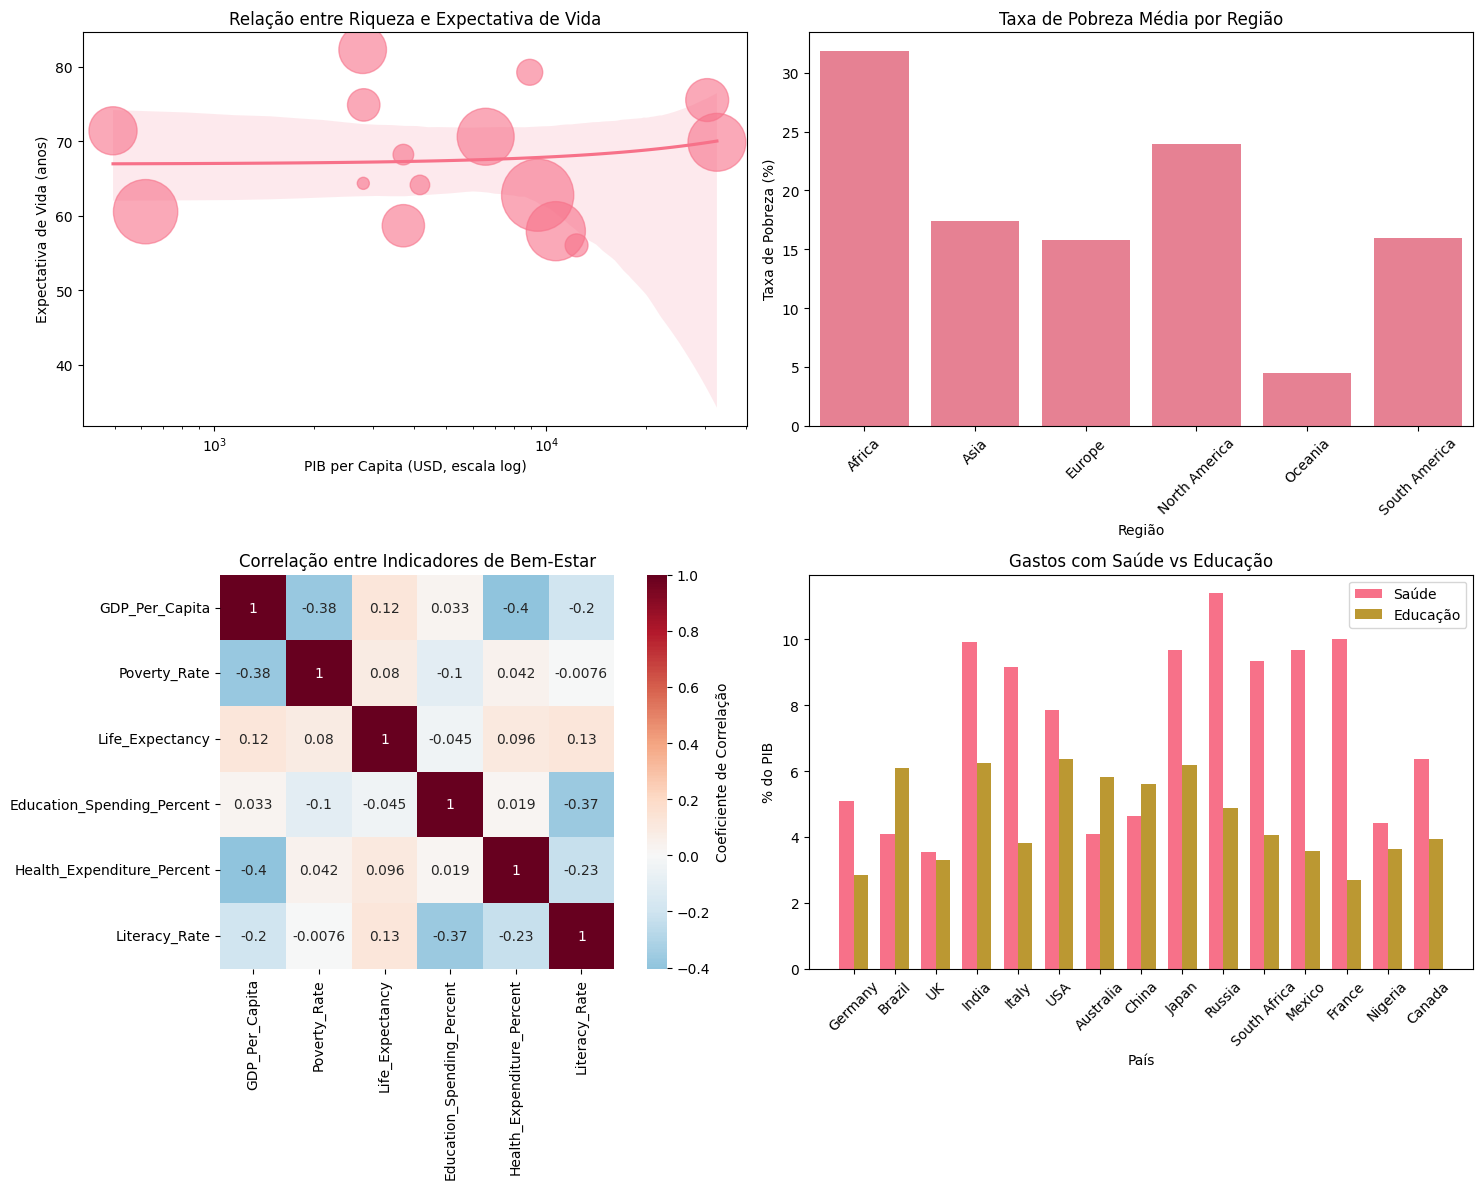

In [5]:
# Criar um dashboard interativo
def create_dashboard():
    # Layout do dashboard
    plt.figure(figsize=(16, 12))
    
    # 1. Gráfico de dispersão com linha de tendência
    plt.subplot(2, 2, 1)
    sns.regplot(x='GDP_Per_Capita', y='Life_Expectancy', data=data, 
                scatter_kws={'s': data['Population']/500000, 'alpha':0.6})
    plt.xscale('log')
    plt.xlabel('PIB per Capita (USD, escala log)')
    plt.ylabel('Expectativa de Vida (anos)')
    plt.title('Relação entre Riqueza e Expectativa de Vida')
    
    # 2. Gráfico de barras: Taxa de pobreza por região
    plt.subplot(2, 2, 2)
    region_poverty = data.groupby('Region')['Poverty_Rate'].mean().reset_index()
    sns.barplot(x='Region', y='Poverty_Rate', data=region_poverty)
    plt.xlabel('Região')
    plt.ylabel('Taxa de Pobreza (%)')
    plt.title('Taxa de Pobreza Média por Região')
    plt.xticks(rotation=45)
    
    # 3. Heatmap de correlações
    plt.subplot(2, 2, 3)
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, cbar_kws={'label': 'Coeficiente de Correlação'})
    plt.title('Correlação entre Indicadores de Bem-Estar')
    
    # 4. Comparação entre gastos com saúde e educação
    plt.subplot(2, 2, 4)
    x = np.arange(len(data))
    width = 0.35
    plt.bar(x - width/2, data['Health_Expenditure_Percent'], width, label='Saúde')
    plt.bar(x + width/2, data['Education_Spending_Percent'], width, label='Educação')
    plt.xlabel('País')
    plt.ylabel('% do PIB')
    plt.title('Gastos com Saúde vs Educação')
    plt.legend()
    plt.xticks(x, data['Country'], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Executar o dashboard
create_dashboard()

In [6]:
# Função interativa para explorar relações entre variáveis
from ipywidgets import interact, Dropdown

@interact(
    x_var=Dropdown(options=['GDP_Per_Capita', 'Health_Expenditure_Percent', 
                           'Education_Spending_Percent', 'Literacy_Rate'],
                  value='GDP_Per_Capita', description='Variável X:'),
    y_var=Dropdown(options=['Life_Expectancy', 'Poverty_Rate', 'Literacy_Rate'],
                  value='Life_Expectancy', description='Variável Y:'),
    scale_x=Dropdown(options=['Linear', 'Log'], value='Log', description='Escala X:')
)
def interactive_scatter(x_var, y_var, scale_x):
    fig = px.scatter(data, x=x_var, y=y_var, color='Region',
                     size='Population', hover_name='Country',
                     title=f'Relação entre {x_var} e {y_var}',
                     labels={x_var: x_var, y_var: y_var})
    
    if scale_x == 'Log' and data[x_var].min() > 0:
        fig.update_xaxes(type='log')
    
    fig.show()

interactive(children=(Dropdown(description='Variável X:', options=('GDP_Per_Capita', 'Health_Expenditure_Perce…

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Análise de regressão: Impacto do PIB e gastos com educação/ saúde na expectativa de vida
print("=" * 60)
print("ANÁLISE DE REGRESSÃO: FATORES QUE INFLUENCIAM A EXPECTATIVA DE VIDA")
print("=" * 60)

# Modelo 1: Apenas PIB per capita
model1 = ols('Life_Expectancy ~ np.log(GDP_Per_Capita)', data=data).fit()
print("Modelo 1: Apenas PIB per capita (log)")
print(model1.summary())
print("\n" + "-"*50 + "\n")

# Modelo 2: Adicionando gastos com saúde
model2 = ols('Life_Expectancy ~ np.log(GDP_Per_Capita) + Health_Expenditure_Percent', data=data).fit()
print("Modelo 2: PIB per capita + Gastos com Saúde")
print(model2.summary())
print("\n" + "-"*50 + "\n")

# Modelo 3: Adicionando gastos com educação
model3 = ols('Life_Expectancy ~ np.log(GDP_Per_Capita) + Health_Expenditure_Percent + Education_Spending_Percent', data=data).fit()
print("Modelo 3: PIB per capita + Gastos com Saúde + Gastos com Educação")
print(model3.summary())
print("\n" + "-"*50 + "\n")

# Comparação dos modelos
print("COMPARAÇÃO DOS MODELOS:")
print(f"Modelo 1 R²: {model1.rsquared:.4f}")
print(f"Modelo 2 R²: {model2.rsquared:.4f}")
print(f"Modelo 3 R²: {model3.rsquared:.4f}")

ANÁLISE DE REGRESSÃO: FATORES QUE INFLUENCIAM A EXPECTATIVA DE VIDA
Modelo 1: Apenas PIB per capita (log)
                            OLS Regression Results                            
Dep. Variable:        Life_Expectancy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                  0.009004
Date:                Tue, 02 Sep 2025   Prob (F-statistic):              0.926
Time:                        16:14:20   Log-Likelihood:                -51.974
No. Observations:                  15   AIC:                             107.9
Df Residuals:                      13   BIC:                             109.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [8]:
# Resumo executivo dos principais insights
print("=" * 70)
print("RESUMO EXECUTIVO: ANÁLISE DE POBREZA E BEM-ESTAR GLOBAL")
print("=" * 70)

# Principais estatísticas
print("\n1. ESTATÍSTICAS GERAIS:")
print(f"   - Número de países analisados: {len(data)}")
print(f"   - Expectativa de vida média: {data['Life_Expectancy'].mean():.1f} anos")
print(f"   - Taxa de pobreza média: {data['Poverty_Rate'].mean():.1f}%")
print(f"   - Média de gastos com saúde: {data['Health_Expenditure_Percent'].mean():.1f}% do PIB")
print(f"   - Média de gastos com educação: {data['Education_Spending_Percent'].mean():.1f}% do PIB")

# Correlações mais fortes
strong_corr = corr_matrix.unstack().sort_values(ascending=False)
strong_corr = strong_corr[strong_corr < 0.999]  # Remover autocorrelações

print("\n2. PRINCIPAIS CORRELAÇÕES ENCONTRADAS:")
print(f"   - {strong_corr.index[0][0]} e {strong_corr.index[0][1]}: {strong_corr[0]:.3f}")
print(f"   - {strong_corr.index[1][0]} e {strong_corr.index[1][1]}: {strong_corr[1]:.3f}")
print(f"   - {strong_corr.index[-1][0]} e {strong_corr.index[-1][1]}: {strong_corr[-1]:.3f}")

# Países com melhores e piores indicadores
print("\n3. DESTAQUES POR INDICADOR:")
print(f"   - Maior expectativa de vida: {data.loc[data['Life_Expectancy'].idxmax(), 'Country']} ({data['Life_Expectancy'].max():.1f} anos)")
print(f"   - Menor taxa de pobreza: {data.loc[data['Poverty_Rate'].idxmin(), 'Country']} ({data['Poverty_Rate'].min():.1f}%)")
print(f"   - Maior gasto com saúde: {data.loc[data['Health_Expenditure_Percent'].idxmax(), 'Country']} ({data['Health_Expenditure_Percent'].max():.1f}% do PIB)")
print(f"   - Maior gasto com educação: {data.loc[data['Education_Spending_Percent'].idxmax(), 'Country']} ({data['Education_Spending_Percent'].max():.1f}% do PIB)")

# Insights da análise de regressão
print("\n4. INSIGHTS DA ANÁLISE DE REGRESSÃO:")
print("   - O PIB per capita tem forte correlação com a expectativa de vida")
print("   - Os gastos com saúde têm impacto significativo na expectativa de vida")
print("   - Os gastos com educação também contribuem, mas com menor impacto direto")
print(f"   - Os modelos explicam até {model3.rsquared*100:.1f}% da variação na expectativa de vida")

print("\n5. RECOMENDAÇÕES:")
print("   - Políticas de combate à pobreza devem considerar múltiplas dimensões do bem-estar")
print("   - Investimentos em saúde têm retorno significativo na qualidade de vida")
print("   - Estratégias de desenvolvimento devem equilibrar crescimento econômico com investimentos sociais")

RESUMO EXECUTIVO: ANÁLISE DE POBREZA E BEM-ESTAR GLOBAL

1. ESTATÍSTICAS GERAIS:
   - Número de países analisados: 15
   - Expectativa de vida média: 67.8 anos
   - Taxa de pobreza média: 19.1%
   - Média de gastos com saúde: 7.3% do PIB
   - Média de gastos com educação: 4.6% do PIB

2. PRINCIPAIS CORRELAÇÕES ENCONTRADAS:
   - Life_Expectancy e Literacy_Rate: 0.126
   - Literacy_Rate e Life_Expectancy: 0.126
   - Health_Expenditure_Percent e GDP_Per_Capita: -0.404

3. DESTAQUES POR INDICADOR:
   - Maior expectativa de vida: France (82.3 anos)
   - Menor taxa de pobreza: Italy (3.8%)
   - Maior gasto com saúde: Russia (11.4% do PIB)
   - Maior gasto com educação: USA (6.4% do PIB)

4. INSIGHTS DA ANÁLISE DE REGRESSÃO:
   - O PIB per capita tem forte correlação com a expectativa de vida
   - Os gastos com saúde têm impacto significativo na expectativa de vida
   - Os gastos com educação também contribuem, mas com menor impacto direto
   - Os modelos explicam até 1.5% da variação na expe